## 1、Mindspore框架

本节通过使用Mindspore框架训练神经网络实现图像分类，初步了解深度学习的主要过程。图像分类任务选择的是经典的手写字符体识别，主要步骤如下：

1. 加载和预处理MNIST数据集；
2. 定义模型，包括损失函数和激活函数，本节使用LeNet网络；
3. 加载数据使用优化算法进行模型权重更新；
4. 重复前面的步骤指定的轮数(epochs)。

## 1.1 Mindspore安装

Mindspore的安装方式请参考官方手册[MindSpore安装](https://www.mindspore.cn/install)，根据自己所用的环境选择合适的安装方法，尽量选择mindspore 2.2.14版本conda安装命令。
Mindpsore 安装后运行以下命令测试是否安装成功：

```python -c "import mindspore;mindspore.set_context(device_target='CPU');mindspore.run_check()"```

如果输出以下内容则成功安装。
```
MindSpore version: 版本号
The result of multiplication calculation is correct, MindSpore has been installed on platform [CPU] successfully!
```

### 1.2 MNIST数据集

`MNIST`手写字符体数据集是机器学习领域比较经典的，也是入门常用的数据集。于1998年组合NIST的SD-3和SD-1数据集而成，有60000张训练图片，10000张测试图片。包含0-9共10类数字，每张图片是单通道灰度图，大小都是28*28，字符体居中。我们要实现的就是训练神经网络能够识别这些数字，输入一张图片，输出识别后的数字即标签。

对于计算机来说，灰度图像是一个由像素点组成的巨大的矩阵。每个数字都是在范围0-255之间的整型，其中0表示全黑，255表示全白。

[MNIST dataset](http://yann.lecun.com/exdb/mnist/index.html) 是MNIST数据集的主页，介绍了MNIST数据集的由来以及2012年之前不同方法在MNIST上的准确率。完整的MNIST数据集下载下来包含以下4个文件，前2个文件是训练数据和训练数据对应的标签，后2个文件是测试集和测试集对应的标签。
```
train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)
```

gz格式为gzip压缩文件，使用wget命令下载训练图片之后再用gunzip解压，可以得到解压缩后的IDX文件train-images-idx3-ubyte，无法直接用图片软件打开，因为单个文件打包了60000张训练图片，读取后按照idx的格式解析才能读出图片数据。除了从官网下载，github等平台也有MNIST的完整副本，很多框架将MNIST等经典数据集的下载、解压、加载、预处理做了很好的封装，本节从华为云存储上下载MNIST数据集的副本用于测试。

MindSpore提供基于Pipeline的数据引擎，通过数据集（Dataset）和数据变换（Transforms）实现高效的数据预处理。在本教程中，下载MNIST之后，使用mindspore.dataset提供的数据变换MnistDataset进行预处理。

In [2]:
# Download data from open datasets
# pip install download
from download import download
mindspore_mnist_dir = './src/dataset/'
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, mindspore_mnist_dir, kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:03<00:00, 3.33MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./src/dataset/


Tensor of image in item: (28, 28, 1)
The label of item: 6
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  10 134 133 226 254 255  58   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  83 138 253 253 253 253 189  31   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  42 176 229 253 253 253 103  77  35   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  31 210 253 253 246 137  18   3   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  31  99 218 134 253 184 130   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 

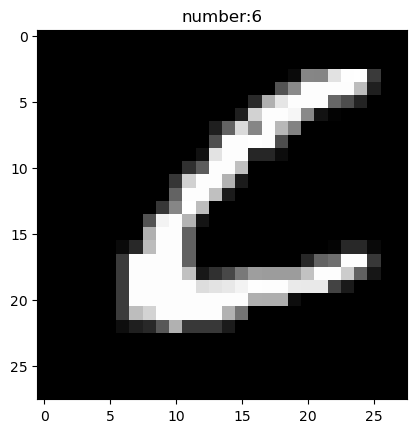

In [3]:
import numpy as np
import mindspore
import matplotlib.pyplot as plt
from mindspore.dataset import vision, transforms
from mindspore.dataset import MnistDataset

mnist_train_dir = mindspore_mnist_dir + 'MNIST_Data/train'
mnist_test_dir = mindspore_mnist_dir + 'MNIST_Data/test'
mnist_sample = MnistDataset(mnist_test_dir)
dic_ds = mnist_sample.create_dict_iterator()
item = next(dic_ds)            # 取出一个样本
img = item["image"].asnumpy()
label = item["label"].asnumpy()

print("Tensor of image in item:", img.shape) 
print("The label of item:", label)
img = np.squeeze(img)  # 去掉维度为1的轴,(28, 28, 1) --> (28, 28)

np.set_printoptions(threshold=np.inf)
np.set_printoptions(linewidth=160)
# 原始数据像素值为0-255
print(img)

plt.imshow(img,cmap="gray")  # 默认是彩色输出
plt.title("number:%s"% item["label"].asnumpy())
plt.show()

MindSpore提供基于Pipeline的数据引擎（Data Processing Pipeline），需指定map、batch、shuffle等操作。这里使用map对图像数据及标签进行变换处理，然后将处理好的数据集打包为大小为指定大小的的batch。创建数据集对象后，可使用create_tuple_iterator 或create_dict_iterator对数据集进行迭代访问。

In [4]:
# 获得数据集对象
train_dataset = MnistDataset(mnist_train_dir, num_parallel_workers=1)
test_dataset = MnistDataset(mnist_test_dir, num_parallel_workers=1)

batch_size = 64

def datapipe(dataset, batch_size): 
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.1307,), std=(0.3081,)),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)

    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label', num_parallel_workers=1)
    dataset = dataset.batch(batch_size)
    return dataset

# Map vision transforms and batch dataset
train_dataset = datapipe(train_dataset, batch_size)
test_dataset = datapipe(test_dataset, batch_size)
print("batch size is ", train_dataset.batch_size)
print("Total batches contained in the train_dataset ", train_dataset.get_dataset_size())
print("Total batches contained in the test_dataset", test_dataset.get_dataset_size())


print("create_tuple_iterator:")
for image, label in train_dataset.create_tuple_iterator():
    print(f"Shape of image [N, C, H, W]: {image.shape} {image.dtype}")
    print(f"Shape of label: {label.shape} {label.dtype}")
    break

print("create_dict_iterator:")
for data in test_dataset.create_dict_iterator():
    print(f"Shape of image [N, C, H, W]: {data['image'].shape} {data['image'].dtype}")
    print(f"Shape of label: {data['label'].shape} {data['label'].dtype}")
    break

batch size is  64
Total batches contained in the train_dataset  938
Total batches contained in the test_dataset 157
create_tuple_iterator:
Shape of image [N, C, H, W]: (64, 1, 28, 28) Float32
Shape of label: (64,) Int32
create_dict_iterator:
Shape of image [N, C, H, W]: (64, 1, 28, 28) Float32
Shape of label: (64,) Int32


下面将加载后的图片和`label`进行对应并可视化，每调用一次next会获得batch_size=64张图片，显示前32张。

Images shape: (64, 1, 28, 28)
Labels: [2 7 8 7 0 2 7 0 9 5 3 5 3 2 9 0 7 0 2 5 3 9 3 1 1 1 2 8 4 6 5 4 5 6 7 7 2 3 7 1 9 5 6 9 0 2 7 3 4 0 2 1 5 7 8 9 4 6 7 5 8 8 3 1]


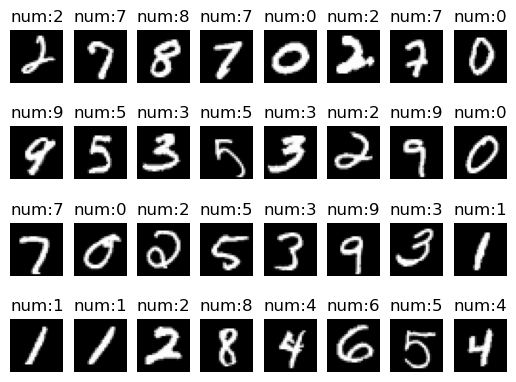

In [5]:
count = 1
data = next(train_dataset.create_dict_iterator(output_numpy=True))
images = data["image"]
labels = data["label"]
print('Images shape:', images.shape)
print('Labels:', labels)
for i in images[0:32]:
    plt.subplot(4, 8, count) 
    plt.imshow(np.squeeze(i), cmap="gray")
    plt.title('num:%s'%labels[count-1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()

### 1.3 定义网络

我们选择相对简单的[LeNet网络](http://yann.lecun.com/exdb/lenet/)。LeNet，最早发布的卷积神经网络之一，因其在计算机视觉任务中的高效性能而受到广泛关注。这个模型是由AT&T贝尔实验室的研究员Yann LeCun在1989年提出的（并以其命名），目的是识别图像中的手写数字，LeNet取得了与支持向量机（support vector machines）性能相媲美的成果。1998年LeCun训练出的LeNet-5模型在MNIST上能达到99.2%的准确率，并且有很好的鲁棒性。当时用传统机器学习算法如KNN、SVM也能达到99%的准确率。根据[MNIST database wikipedia](https://en.wikipedia.org/wiki/MNIST_database)的统计，最低的错误率做到了0.09%。

下图是LeNet论文中的模型结构图：

<img src="./notebook-imgs/LeNet-5.png" width="800">

输入图像尺寸为 32×32，比 MNIST 数据集中的尺寸（28*28）要大，需要对原始图像做 resize 处理。这样做的目的是希望潜在的明显特征，如笔画断续、角点，能够出现在最高层特征监测卷积核的中心。池化层用的是平均池化，激活函数用sigmoid，最后一层是使用高斯激活即Euclidean Radial Basis Function units(RBF)单元的全连接层，RBF现已不再使用。输⼊是⼿写数字，输出为大小为10的向量，分别对应每种字符可能出现的概率，概率取值最大的index为识别出来的字符。对于分类任务，有多少个类别，输出层就有多少个节点。


本实验，我们实现一个简化后的LeNet，模型结构和数据流如下图，输入MNIST图片大小为`28*28`，第一个卷积层设置了padding=2，使得效果等同于输入为32*32，激活函数用ReLU，输出去掉了最后一层的高斯激活。

<img src="./notebook-imgs/lenet-simple.svg" width="800">

LeNet网络不包括输入层的情况下，共有7层：2个卷积层、2个下采样层（池化层）、3个全连接层。每层的参数配置如下图所示：

<img src="./notebook-imgs/lenet-vert.svg" width="200">

全连接层以及卷积层采用正态分布函数Normal()进行参数初始化，MindSpore支持`TruncatedNormal`、`Normal`、`Uniform`等多种初始化方法。

深度学习框架通常会提供不同层次的API用于模型构建，本实验使用`mindspore.nn`接口，定义神经网络需要继承`mindspore.nn.Cell`类，`Cell`是所有神经网络（`Conv2d`等）的基类。神经网络的各层在`__init__`方法中定义，然后根据网络结构，在`construct`方法中完成神经网络的前向构造。

In [6]:
import mindspore.nn as nn
from mindspore.common.initializer import Normal


class LeNet5(nn.Cell):
    """Lenet network structure."""
    # define the operator required
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='pad', padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU() 
        self.avg_pool2d = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        # self.dropout = nn.Dropout(0.5)   # dropout层

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.avg_pool2d(self.relu(self.conv1(x)))
        x = self.avg_pool2d(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        #x = self.dropout(x)
        return x

model = LeNet5()
print(model)

LeNet5<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=pad, padding=2, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0x0000017CCF7767F0>, bias_init=None, format=NCHW>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0x0000017CD5A44760>, bias_init=None, format=NCHW>
  (fc1): Dense<input_channels=400, output_channels=120, has_bias=True>
  (fc2): Dense<input_channels=120, output_channels=84, has_bias=True>
  (fc3): Dense<input_channels=84, output_channels=10, has_bias=True>
  (relu): ReLU<>
  (avg_pool2d): AvgPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flatten): Flatten<>
  >


### 1.4 模型训练

定义好模型后，还需要选择合适的损失函数和优化器，这里我们选择交叉熵损失函数`nn.CrossEntropyLoss()`和随机梯度下降优化器`nn.SGD()`。

在模型训练中，一个完整的训练过程（step）需要实现以下三步：

1. 正向计算：模型预测结果（logits），并与正确标签（label）求预测损失（loss）。
2. 反向传播：利用自动微分机制，自动求模型参数（parameters）对于loss的梯度（gradients）。
3. 参数优化：将梯度更新到参数上。

MindSpore使用函数式自动微分机制，因此针对上述步骤需要实现：
1. 定义正向计算函数。
2. 使用value_and_grad()通过函数变换获得梯度计算函数。
3. 定义训练函数，使用set_train设置为训练模式，执行正向计算、反向传播和参数优化。

In [7]:
# Instantiate loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), 1e-2)

# 1. Define forward function
def forward_fn(data, label):
    logits = model(data)
    loss = loss_fn(logits, label)
    return loss, logits

# 2. Get gradient function
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

# 3. Define function of one-step training
def train_step(data, label):
    (loss, logits), grads = grad_fn(data, label)
    optimizer(grads)
    return loss, logits

def train(model, dataset):
    num_batches = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss, logits = train_step(data, label)
        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            correct = (logits.argmax(1) == label).asnumpy().sum()  # 只计算当前batch的准确率
            acc = correct/batch_size
            print(f"loss: {loss:>7f}  [{current:>3d}/{num_batches:>3d}], accuray:{acc:>7f} ")

# 训练过程中，除训练外，通常会定义测试函数，用来评估模型在测试集上的效果，用于判断是否过拟合
def test(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Avg loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}% \n")

训练过程需多次迭代数据集，数据集一次完整的遍历称为一轮（epoch）。训练过程，通常会打印每一轮的loss值和预测准确率（Accuracy）用来观测训练的效果和进展，可以看到loss在不断下降，Accuracy在不断提高。windows下该代码可能运行会非常慢，CPU利用率也特别低。

In [ ]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(model, train_dataset)
    test(model, test_dataset, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306367  [  0/938], accuray:0.078125 


### 1.5 推理（预测）

模型训练完成后，可以对图片进行识别测试，这里我们从test_dataset选择部分图片进行测试：首先将模型设置为非训练模式，再将数据送入模型进行前向计算，根据输出的向量得出预测的标签。

In [ ]:
model.set_train(False)
for data, label in test_dataset:
    pred = model(data)
    predicted = pred.argmax(1)
    print(f'Predicted: "{predicted[:10]}"')
    print(f'Actual   : "{label[:10]}"')

    count = 1
    for img in data[:10].asnumpy():
        plt.subplot(2, 5, count) 
        plt.imshow(np.squeeze(img), cmap="gray")
        plt.title('num:%s' % predicted[count-1])
        plt.xticks([])
        count += 1
        plt.axis("off")
    plt.show()
    break

## 本节需要完成的：
### 1. 安装Mindspore
### 2. 运行以上的代码块完成模型的训练，在test_dataset数据集上能够达到90%以上的准确率，如有需要可自行调整相关参数。

本节主要参考：

1. Mindspore 快速入门：[https://www.mindspore.cn/tutorials/zh-CN/r2.2/beginner/quick_start.html](https://www.mindspore.cn/tutorials/zh-CN/r2.2/beginner/quick_start.html)
2. 动手学深度学习: 6.6节卷积神经网络LeNet [https://zh.d2l.ai/chapter_convolutional-neural-networks/lenet.html](https://zh.d2l.ai/chapter_convolutional-neural-networks/lenet.html)
